In [2]:
# Modules for debugging

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler
from joblib import parallel_backend
import shap


# Custom modules
from preprocessing_post_fastsurfer.alignment import *
from preprocessing_post_fastsurfer.cropping import *
from preprocessing_post_fastsurfer.extraction import *
from preprocessing_post_fastsurfer.file_handling import *
from preprocessing_post_fastsurfer.mesh_creation import *
from preprocessing_post_fastsurfer.subject import *
from preprocessing_post_fastsurfer.vis import *

# Custom modules
from ozzy_torch_utils.split_dataset import *
from ozzy_torch_utils.subject_dataset import *

np.set_printoptions(precision=2, suppress=True)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
data_path = "/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/scratch-disk/full-datasets/hcampus-1.5T-cohort"

selected_labels = ['CN', 'MCI']

# Dictionary key representing the disease labels
labels_string = 'research_group'


In [4]:
dataset = SubjectDataset(data_path, selected_labels, data_string='scores')

Csv files: ['/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/scratch-disk/full-datasets/hcampus-1.5T-cohort/idaSearch_3_19_2025.csv']


In [5]:
labels = np.array([dataset[index]['research_group'] for index in range(len(dataset.subject_list))])

scores = np.array([dataset[index]['scores'] for index in range(len(dataset.subject_list))])

In [6]:
scoring = 'roc_auc'

with parallel_backend('threading', n_jobs=8):

    model = HistGradientBoostingClassifier(learning_rate=0.0001, max_iter=4, max_leaf_nodes=4, l2_regularization=4.0, min_samples_leaf=150, max_depth=2, class_weight='balanced', scoring=scoring)

    # Need to implement k fold with non-leakage datasets, there could be leakage here if single_img_per_subject is not selected
    cv = StratifiedKFold(n_splits=10, shuffle=True)

    cv_scores = cross_val_score(model, scores, labels, cv=cv, scoring=scoring)

    print(f'Cross-validation {scoring} scores: {cv_scores}')
    print(f'Mean cross-validation {scoring}: {np.mean(cv_scores)}')
    print(f'Standard deviation of cross-validation {scoring}: {np.std(cv_scores)}')

Cross-validation roc_auc scores: [0.77 0.83 0.69 0.78 0.74 0.77 0.75 0.74 0.81 0.63]
Mean cross-validation roc_auc: 0.7507839451570101
Standard deviation of cross-validation roc_auc: 0.05369226182526346


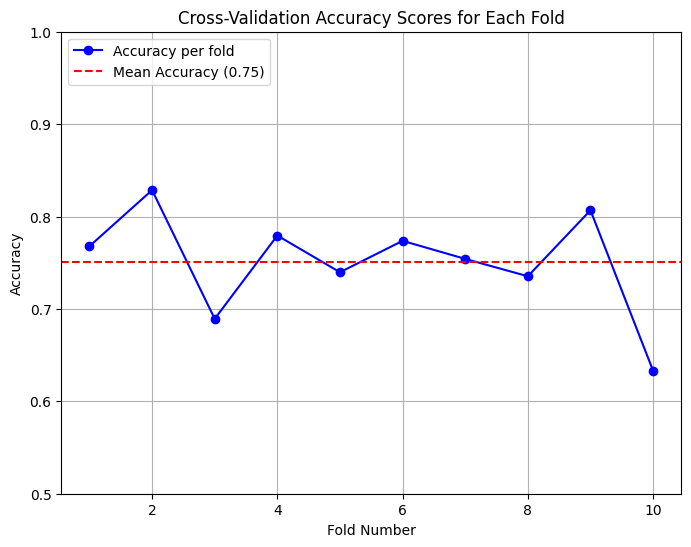

In [7]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cv_scores) + 1), cv_scores, marker='o', color='b', linestyle='-', label='Accuracy per fold')
plt.axhline(y=np.mean(cv_scores), color='r', linestyle='--', label=f'Mean Accuracy ({np.mean(cv_scores):.2f})')
plt.title('Cross-Validation Accuracy Scores for Each Fold')
plt.xlabel('Fold Number')
plt.ylabel('Accuracy')
plt.ylim(0.5,1)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

543


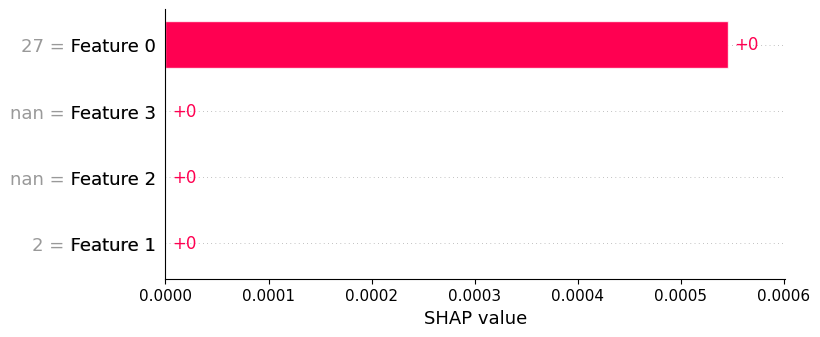

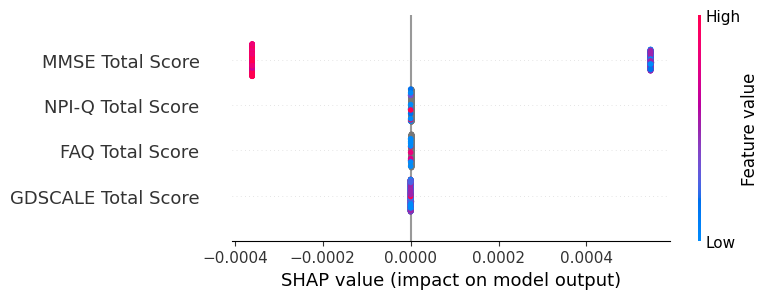

In [8]:
model.fit(scores, labels)

explainer = shap.Explainer(model)

shap_values = explainer(scores)

print(len(shap_values))

shap.plots.bar(shap_values[0], max_display=10)

shap.summary_plot(shap_values, scores, feature_names=dataset[0]['score_names'])

Cross-validation roc_auc scores: [0.82 0.9  0.82 0.77 0.84 0.93 0.88 0.86 0.86 0.88]
Mean cross-validation roc_auc: 0.8566786819991155
Standard deviation of cross-validation roc_auc: 0.043157829912857375


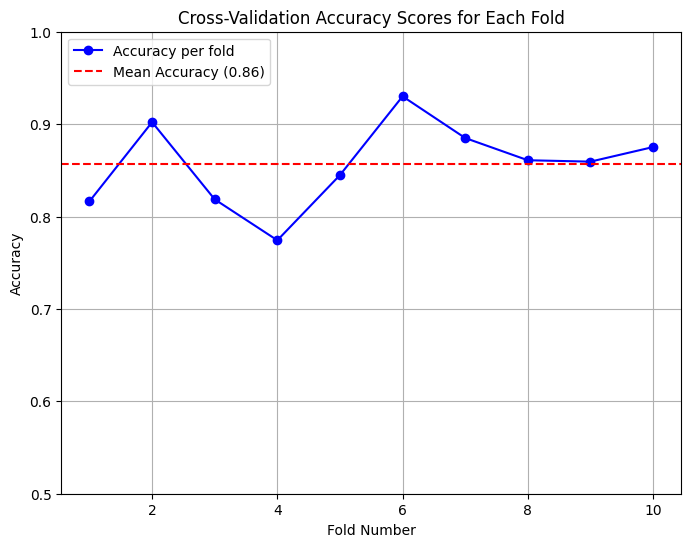

In [9]:
scoring = 'roc_auc'

with parallel_backend('threading', n_jobs=8):

    model = RandomForestClassifier(n_estimators=100, max_depth=None, class_weight='balanced')

    # Need to implement k fold with non-leakage datasets, there could be leakage here if single_img_per_subject is not selected
    cv = StratifiedKFold(n_splits=10, shuffle=True)

    cv_scores = cross_val_score(model, scores, labels, cv=cv, scoring=scoring)

    print(f'Cross-validation {scoring} scores: {cv_scores}')
    print(f'Mean cross-validation {scoring}: {np.mean(cv_scores)}')
    print(f'Standard deviation of cross-validation {scoring}: {np.std(cv_scores)}')

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cv_scores) + 1), cv_scores, marker='o', color='b', linestyle='-', label='Accuracy per fold')
plt.axhline(y=np.mean(cv_scores), color='r', linestyle='--', label=f'Mean Accuracy ({np.mean(cv_scores):.2f})')
plt.title('Cross-Validation Accuracy Scores for Each Fold')
plt.xlabel('Fold Number')
plt.ylabel('Accuracy')
plt.ylim(0.5,1)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

543


TypeError: 'numpy.float64' object is not iterable

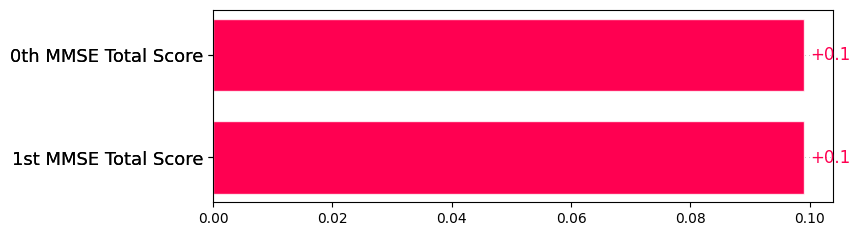

In [10]:
model.fit(scores, labels)

explainer = shap.Explainer(model, feature_names=dataset[0]['score_names'])

shap_values = explainer(scores)

print(len(shap_values))

# shap.plots.bar(shap_values[0], max_display=10)

shap.plots.bar(shap_values[0], max_display=10)